In [ ]:
from tensorflow.keras.applications import ResNet50,EfficientNetB0,VGG16,inception_v3
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, GlobalAveragePooling2D, UpSampling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [ ]:

# Define paths - update these to match your environment
QUANTUM_FEATURES_PATH = "/content/drive/MyDrive/quantum_xray_results/quantum_features/quantum_features.npy"
DATA_SPLITS_PATH = "/content/drive/MyDrive/quantum_xray_results/data_splits/data_splits_converted.pkl"

In [ ]:
# Quantum Features + ResNet Classification - Fixed Dimensions

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Load the quantum features and data splits
print("Loading quantum features and data splits...")
quantum_features = np.load(QUANTUM_FEATURES_PATH)
with open(DATA_SPLITS_PATH, 'rb') as f:
    splits = pickle.load(f)

# Extract train and test indices
train_indices = splits['train_indices']
test_indices = splits['test_indices']
train_labels = splits['train_labels']
test_labels = splits['test_labels']

# Get the features for training and testing
X_train = quantum_features[train_indices]
X_test = quantum_features[test_indices]
y_train = train_labels
y_test = test_labels


print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {X_test.shape}, Labels: {y_test.shape}")

# Determine the upsampling factor needed
# First, let's print the current shape to understand what we're working with
print(f"Quantum features shape: {X_train.shape[1:]}")





Loading quantum features and data splits...
Training set: (658, 112, 112, 4), Labels: (658,)
Testing set: (165, 112, 112, 4), Labels: (165,)
Quantum features shape: (112, 112, 4)


In [ ]:
#array of size 823

arr = np.zeros(823)


In [ ]:
for i in range(len(test_indices)):
  arr[test_indices[i]] = test_labels[i]

for i in range(len(train_indices)):
  arr[train_indices[i]] = train_labels[i]

In [ ]:
X = quantum_features
y = arr

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_quantum_channels(quantum_img, cmap='gray'):
    """
    Displays each of the 4 channels in the quantum-processed image separately.

    Args:
        quantum_img (np.array): shape (H, W, 4)
        cmap (str): Colormap for visualization
    """
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        ax = axes[i]
        channel_img = quantum_img[:, :, i]
        ax.imshow(channel_img, cmap=cmap)
        ax.set_title(f"Qubit Channel {i+1}")
        ax.axis('off')

    plt.suptitle("Individual Quantum Channels", fontsize=16)
    plt.tight_layout()
    plt.show()


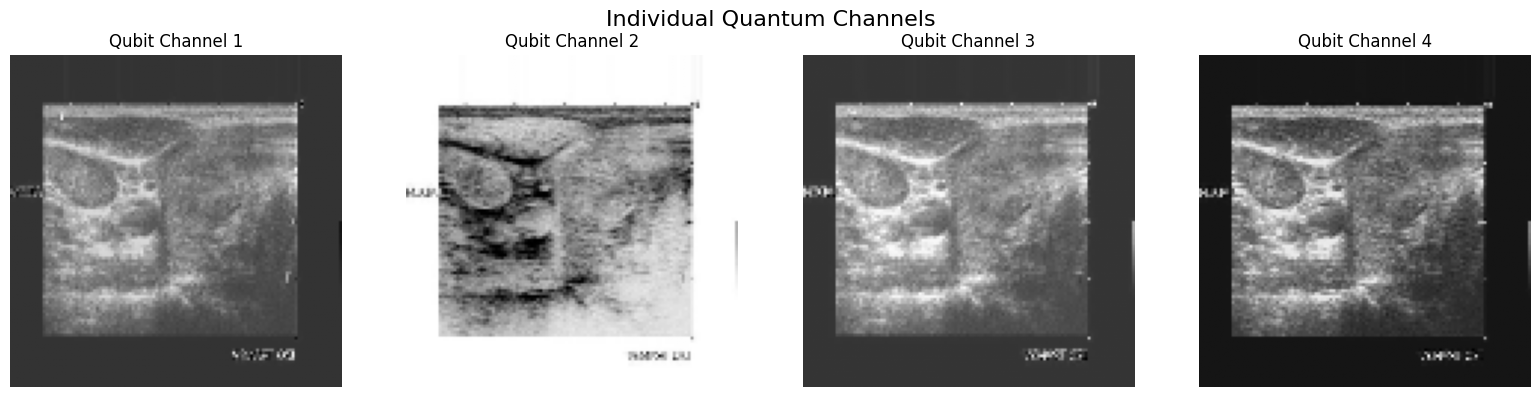

In [ ]:
display_quantum_channels(X_train[0])


In [ ]:
# def prepare_for_resnet(quantum_features):

#     unfreeze_layers = 15
#     """
#     Prepare quantum features for ResNet by adding a preprocessing network
#     that correctly sizes the input to match ResNet's expectations (224x224x3)
#     """
#     # Get the shape of our quantum features
#     h, w, c = quantum_features.shape[1:]

#     # Create input layer for our quantum features
#     inputs = Input(shape=(h, w, c))

#     # Use convolutions to process the features
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

#     # Calculate how many upsampling steps we need
#     # For example, if h=112, we need factor of 2 to get to 224
#     upsampling_factor = 224 // h

#     # Apply upsampling to reach 224x224
#     if upsampling_factor > 1:
#         x = UpSampling2D(size=(upsampling_factor, upsampling_factor))(x)

#     # Now we use a 1x1 convolution to map to 3 channels (RGB)
#     quantum_processed = Conv2D(3, (1, 1), padding='same')(x)

#     # Ensure the output shape is exactly what ResNet expects
#     print(f"Shape after preprocessing: {quantum_processed.shape}")

#     # Use a pretrained ResNet50 without the top classification layer
#     #model_base = ResNet50(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
#     #model_base = EfficientNetB0(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
#     model_base = VGG16(include_top=False, input_shape=(224, 224, 3),weights='imagenet')
#     #model_base = inception_v3.InceptionV3(include_top=False, input_shape=(224, 224, 3),weights='imagenet')
#     # Freeze the ResNet weights
#     for layer in model_base.layers:
#         layer.trainable = False

#     # Unfreeze the last `unfreeze_layers` layers for fine-tuning
#     for layer in model_base.layers[-unfreeze_layers:]:
#         layer.trainable = True


#     # Connect our processed quantum features to the ResNet
#     resnet_features = model_base(quantum_processed)

#     # Add classification head
#     x = GlobalAveragePooling2D()(resnet_features)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.5)(x)  # Add dropout for regularization
#     outputs = Dense(1, activation='sigmoid')(x)

#     # Create the full model
#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# # Define parameters
# batch_size = 16
# epochs = 50

# # Create and compile the model
# print("Creating and compiling the model...")
# model = prepare_for_resnet(X_train_norm)
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.AUC()])

# # Display model summary
# model.summary()

# # Set up callbacks for training
# early_stopping = EarlyStopping(
#     restore_best_weights=True,
#     patience = 50,
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )

# # Train the model
# print("Training the model...")
# history = model.fit(
#     X_train_norm, y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_split=0.2,
#     callbacks=[ early_stopping, reduce_lr]
# )


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.6082 - auc_5: 0.5003 - loss: 0.7171 - val_accuracy: 0.6288 - val_auc_5: 0.8976 - val_loss: 0.6558 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.8456 - auc_5: 0.8799 - loss: 0.3534 - val_accuracy: 0.6288 - val_auc_5: 0.8976 - val_loss: 0.6396 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8367 - auc_5: 0.8863 - loss: 0.3125 - val_accuracy: 0.6288 - val_auc_5: 0.8976 - val_loss: 0.6225 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8405 - auc_5: 0.8910 - loss: 0.3157 - val_accuracy: 0.6288 - val_auc_5: 0.8976 - val_loss: 0.5768 - learning_rate: 1.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.8484 - auc_5: 0.8866 - loss: 0.3046 - val_accuracy: 0.6288 - val_auc_5: 0.8976 - val_loss: 0.5040 - learning_rate: 1.0000e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 

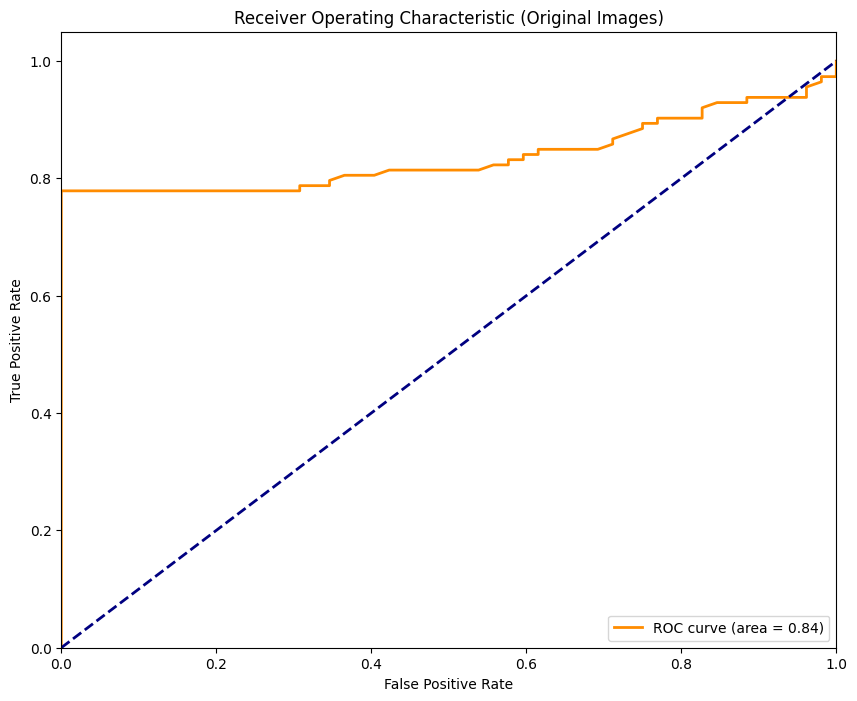

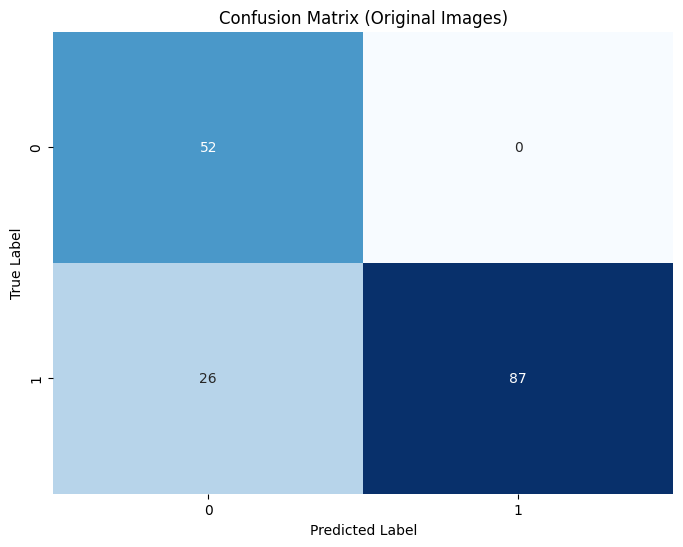


Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        52
         1.0       1.00      0.77      0.87       113

    accuracy                           0.84       165
   macro avg       0.83      0.88      0.83       165
weighted avg       0.89      0.84      0.85       165

Test accuracy: 0.8424
Precision: 1.0000
Recall (Sensitivity): 0.7699
F1 Score: 0.8700
All results saved to: /content/drive/MyDrive/resnet_results


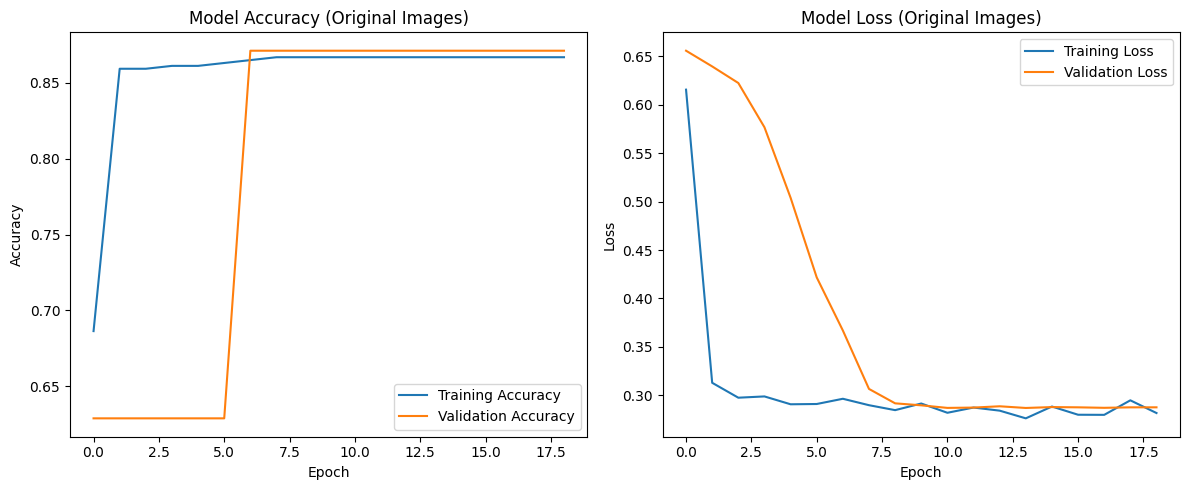

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 837ms/step - accuracy: 0.5799 - auc_6: 0.4709 - loss: 0.6865 - val_accuracy: 0.6288 - val_auc_6: 0.5000 - val_loss: 0.6886 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.6638 - auc_6: 0.5701 - loss: 0.6318 - val_accuracy: 0.3712 - val_auc_6: 0.0904 - val_loss: 0.7005 - learning_rate: 1.0000e-04
Epoch 3/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6806 - auc_6: 0.6582 - loss: 0.6046
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6814 - auc_6: 0.6610 - loss: 0.6034 - val_accuracy: 0.3712 - val_auc_6: 0.0904 - val_loss: 0.7246 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7435 - auc_6: 0.8450 - loss: 0.4901 - val_accuracy: 0.3712 - val_auc_6: 0.5000 - val_loss: 0.7665 - learning_rate: 5.0000e-05
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.76

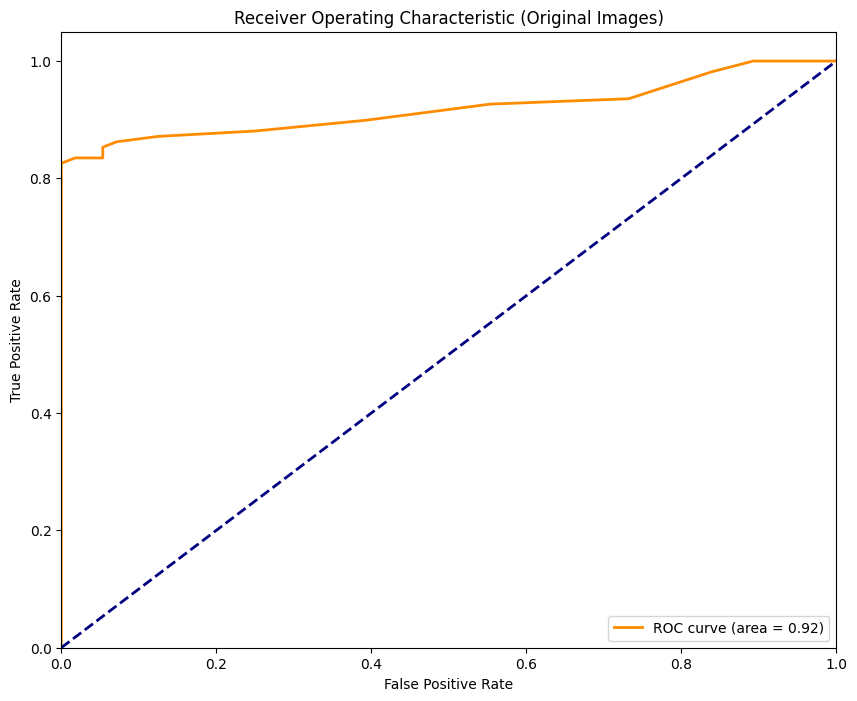

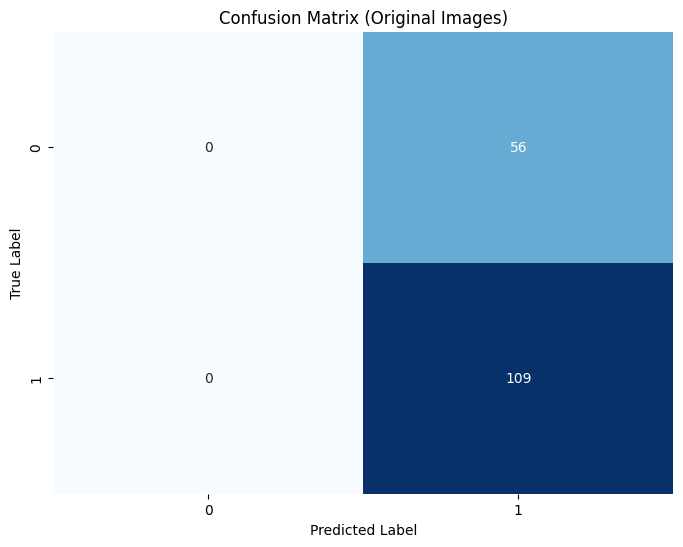


Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        56
         1.0       0.66      1.00      0.80       109

    accuracy                           0.66       165
   macro avg       0.33      0.50      0.40       165
weighted avg       0.44      0.66      0.53       165

Test accuracy: 0.6606
Precision: 0.6606
Recall (Sensitivity): 1.0000
F1 Score: 0.7956
All results saved to: /content/drive/MyDrive/efficientnet_results


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


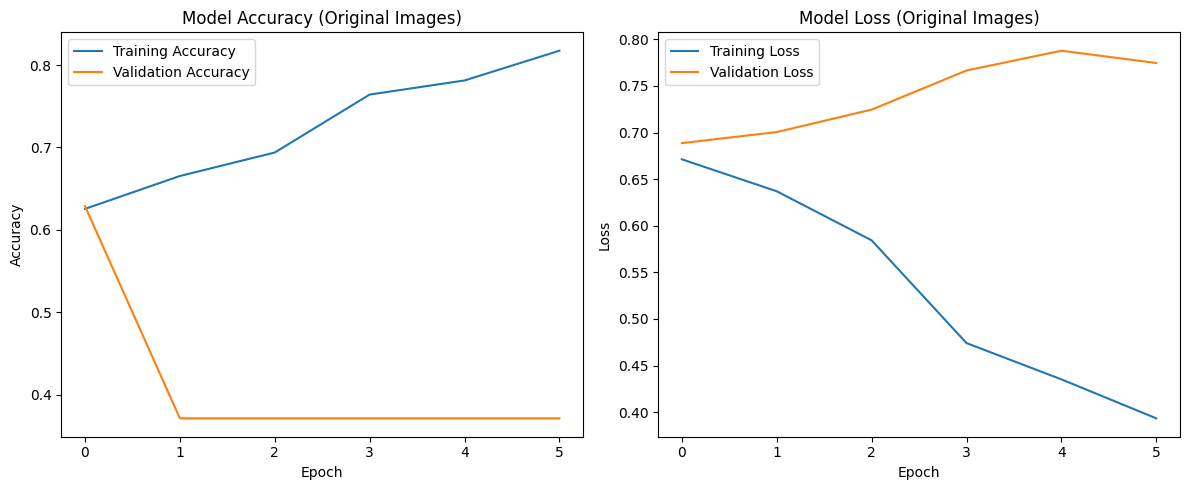

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6744 - auc_7: 0.7228 - loss: 0.5318 - val_accuracy: 0.8788 - val_auc_7: 0.9121 - val_loss: 0.2583 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.8218 - auc_7: 0.8807 - loss: 0.3166 - val_accuracy: 0.8788 - val_auc_7: 0.9121 - val_loss: 0.2585 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8629 - auc_7: 0.8937 - loss: 0.2918
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.8625 - auc_7: 0.8934 - loss: 0.2924 - val_accuracy: 0.8788 - val_auc_7: 0.9121 - val_loss: 0.2603 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.8566 - auc_7: 0.9159 - loss: 0.2774 - val_accuracy: 0.8788 - val_auc_7: 0.9121 - val_loss: 0.2566 - learning_rate: 5.0000e-05
Epoch 5/50
33/

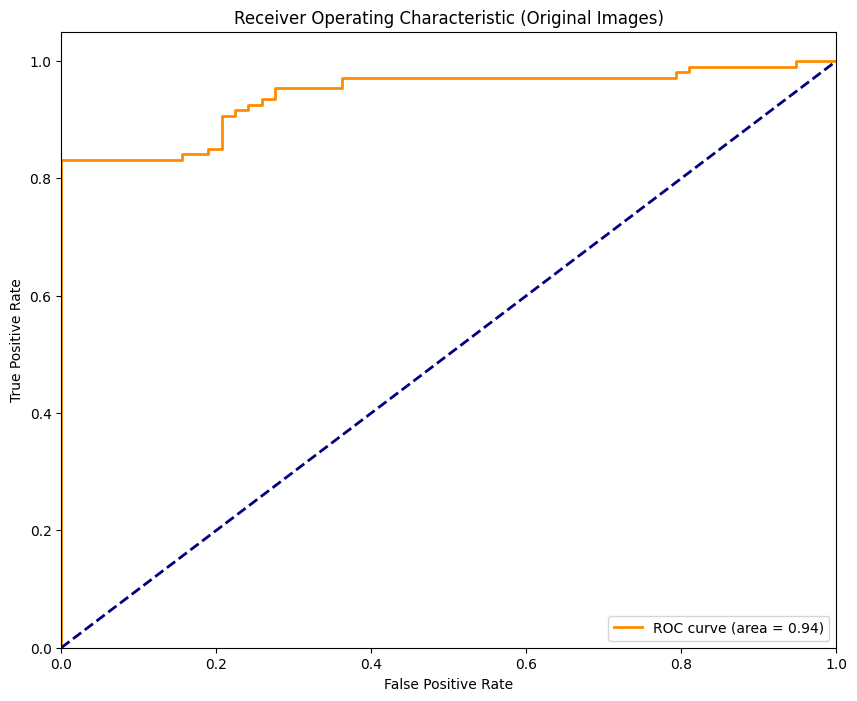

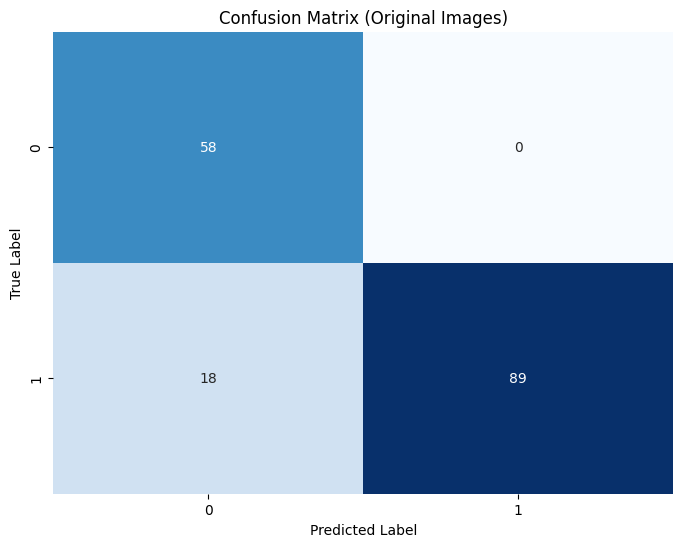


Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.87        58
         1.0       1.00      0.83      0.91       107

    accuracy                           0.89       165
   macro avg       0.88      0.92      0.89       165
weighted avg       0.92      0.89      0.89       165

Test accuracy: 0.8909
Precision: 1.0000
Recall (Sensitivity): 0.8318
F1 Score: 0.9082
All results saved to: /content/drive/MyDrive/vgg_results


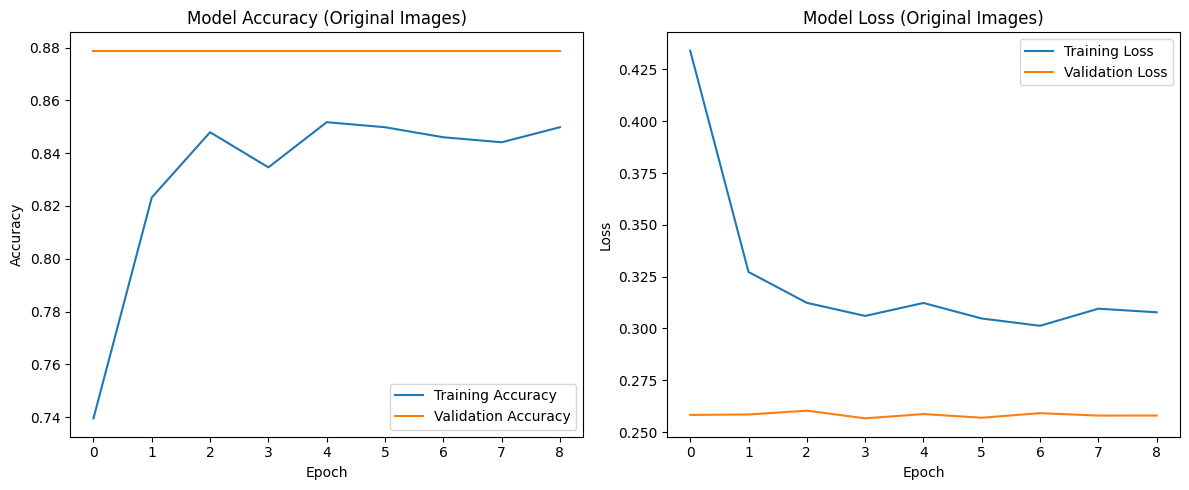

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 931ms/step - accuracy: 0.7770 - auc_8: 0.8535 - loss: 0.4214 - val_accuracy: 0.8409 - val_auc_8: 0.9173 - val_loss: 0.3240 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8634 - auc_8: 0.8993 - loss: 0.3014 - val_accuracy: 0.8409 - val_auc_8: 0.8859 - val_loss: 0.3083 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8653 - auc_8: 0.8992 - loss: 0.2955 - val_accuracy: 0.8409 - val_auc_8: 0.8887 - val_loss: 0.3023 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.8631 - auc_8: 0.8992 - loss: 0.2882 - val_accuracy: 0.8409 - val_auc_8: 0.8944 - val_loss: 0.3022 - learning_rate: 1.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8660 - auc_8: 0.9058 - loss: 0.2791 - val_accuracy: 0.8409 - val_auc_8: 0.9277 - val_loss: 0.3007 - learning_rate

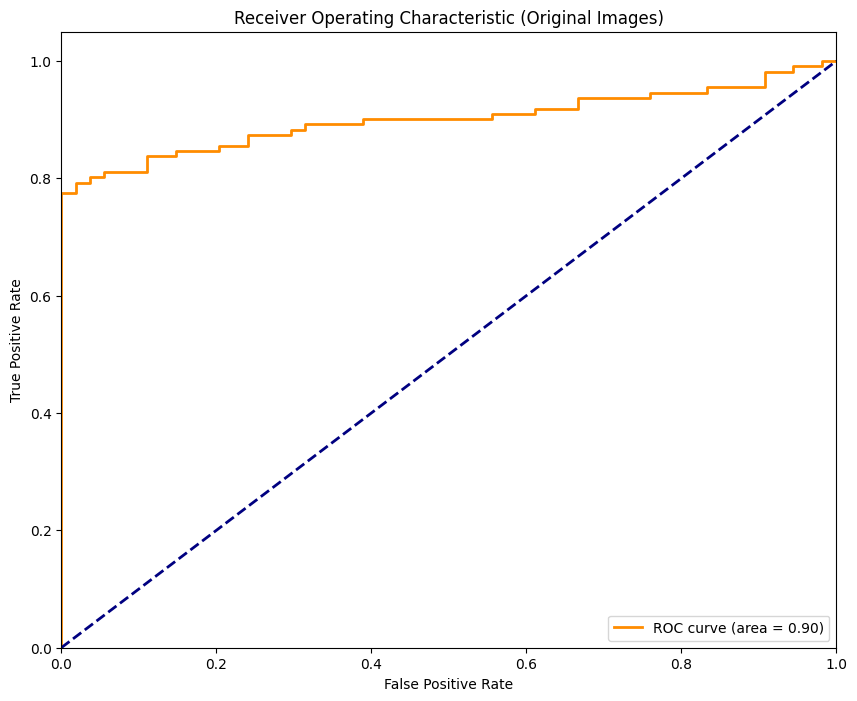

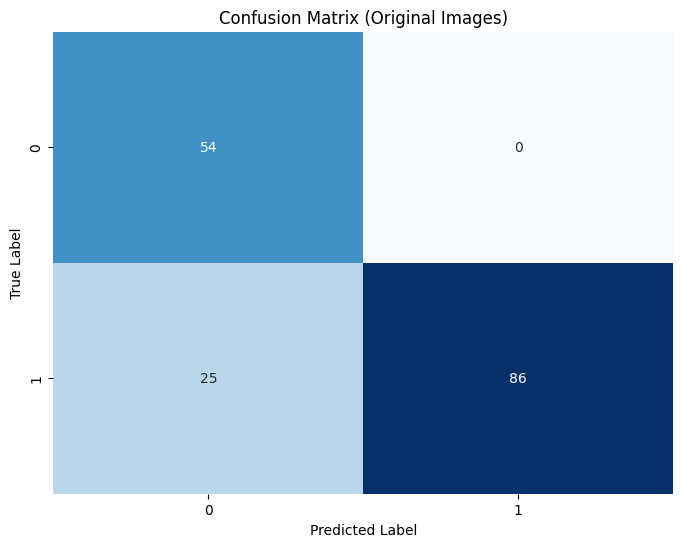


Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        54
         1.0       1.00      0.77      0.87       111

    accuracy                           0.85       165
   macro avg       0.84      0.89      0.84       165
weighted avg       0.90      0.85      0.85       165

Test accuracy: 0.8485
Precision: 1.0000
Recall (Sensitivity): 0.7748
F1 Score: 0.8731
All results saved to: /content/drive/MyDrive/inception_results


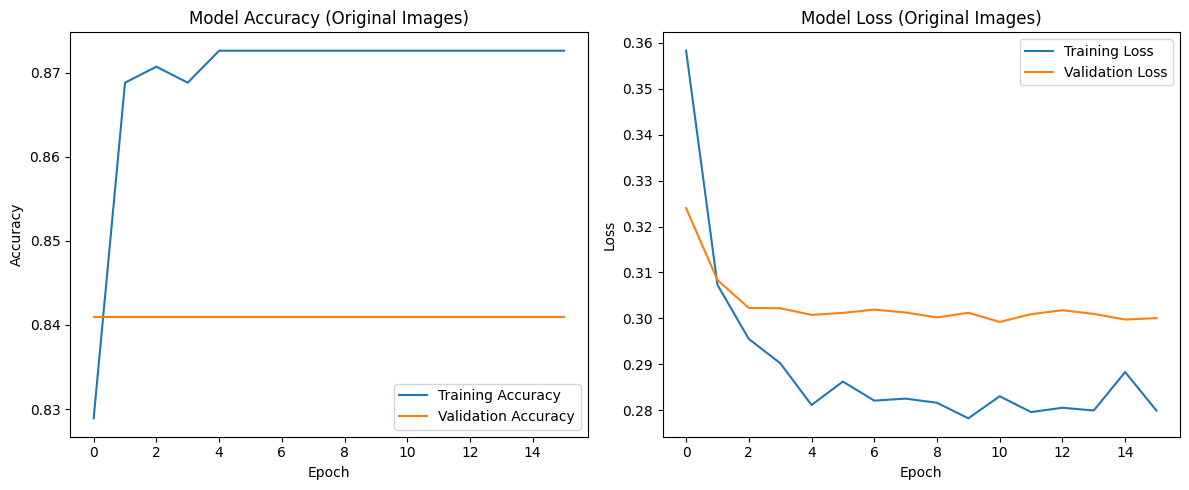

In [ ]:
def prepare_for_resnet(quantum_features, model_name='inception'):
    # Get the shape of our quantum features
    h, w, c = quantum_features.shape[1:]

    # Create input layer for our quantum features
    inputs = Input(shape=(h, w, c))

    # Preprocessing
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Upsampling
    upsampling_factor = 224 // h
    if upsampling_factor > 1:
        x = UpSampling2D(size=(upsampling_factor, upsampling_factor))(x)

    # Convert to 3 channels
    quantum_processed = Conv2D(3, (1, 1), padding='same')(x)

    # Select base model dynamically
    if model_name == 'resnet':
        model_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif model_name == 'efficientnet':
        model_base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif model_name == 'vgg':
        model_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    else:  # default to inception
        model_base = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Option to fine-tune: unfreeze some top layers

    for layer in model_base.layers:
        layer.trainable = False

    for layer in model_base.layers[-15:]:
        layer.trainable = True

    # Connect quantum features to base model
    resnet_features = model_base(quantum_processed)

    # Classification head
    x = GlobalAveragePooling2D()(resnet_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    outputs = Dense(1, activation='sigmoid')(x)

    # Create full model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
models_to_try = ['resnet', 'efficientnet', 'vgg', 'inception']
results = {}

for model_name in models_to_try:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)
    X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test_norm = (X_test - X_test.min()) / (X_test.max() - X_test.min())
    OUTPUT_DIR = f"/content/drive/MyDrive/{model_name}_results"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Recreate model for each iteration
    model = prepare_for_resnet(X_train_norm, model_name=model_name)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

    batch_size = 16
    epochs = 50
    # Set up callbacks for training
    early_stopping = EarlyStopping(
        restore_best_weights=True,
        patience = 5,
        verbose=1,
        monitor='val_loss',
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    # Train model
    history = model.fit(
        X_train_norm, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test_norm)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    #_________________________________________plot________________________________________________________
    # Calculate and plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
            label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Original Images)')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
    plt.show()

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix (Original Images)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


    # Calculate additional metrics
    test_acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Save a summary of the results
    with open(os.path.join(OUTPUT_DIR, 'results_summary.txt'), 'w') as f:
        f.write(f"Original Images + ResNet Classification Results\n")
        f.write(f"==============================================\n\n")
        f.write(f"Test accuracy: {test_acc:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall (Sensitivity): {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")

    print(f"All results saved to: {OUTPUT_DIR}")


    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy (Original Images)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (Original Images)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
    plt.show()

# Print comparative results
for model, metrics in results.items():
    print(f"\n{model.upper()} Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

In [ ]:


# # Make predictions
# y_pred_prob = model.predict(X_test_norm)
# y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# # Calculate and plot the ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(10, 8))
# plt.plot(fpr, tpr, color='darkorange', lw=2,
#          label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (Original Images)')
# plt.legend(loc="lower right")
# plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
# plt.show()

# # Plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title('Confusion Matrix (Original Images)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.show()

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


# # Calculate additional metrics
# test_acc = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1_score = f1_score(y_test, y_pred)

# # Save a summary of the results
# with open(os.path.join(OUTPUT_DIR, 'results_summary.txt'), 'w') as f:
#     f.write(f"Original Images + ResNet Classification Results\n")
#     f.write(f"==============================================\n\n")
#     f.write(f"Test accuracy: {test_acc:.4f}\n")
#     f.write(f"Precision: {precision:.4f}\n")
#     f.write(f"Recall (Sensitivity): {recall:.4f}\n")
#     f.write(f"F1 Score: {f1_score:.4f}\n")

# print(f"All results saved to: {OUTPUT_DIR}")



In [ ]:

# # Plot training history
# plt.figure(figsize=(12, 5))

# # Plot accuracy
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy (Original Images)')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss (Original Images)')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
# plt.show()


In [ ]:
# print(y_train)# Visualize a few samples with their predictions
# def visualize_predictions(model, X_test, y_test, num_samples=5):
#     """Visualize predictions for a few samples"""
#     # Get random samples
#     sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
#     X_samples = X_test[sample_indices]
#     y_samples = y_test[sample_indices]

#     # Get predictions
#     y_pred_prob = model.predict(X_samples)
#     y_pred = (y_pred_prob > 0.5).astype(int).flatten()

#     # Plot
#     plt.figure(figsize=(15, num_samples * 3))
#     for i in range(num_samples):
#         plt.subplot(num_samples, 1, i+1)
#         plt.imshow(np.mean(X_samples[i], axis=2), cmap='viridis')
#         plt.title(f"True: {y_samples[i]}, Pred: {y_pred[i]} (Prob: {y_pred_prob[i][0]:.2f})")
#         plt.colorbar()

#     plt.tight_layout()
#     plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_visualization.png'))
#     plt.show()

# # Visualize some predictions
# visualize_predictions(model, X_test_norm, y_test)

In [ ]:
# print(test_acc)